Found 1268 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 345 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.6563 - loss: 0.5940 - val_accuracy: 0.7130 - val_loss: 0.4299
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.7970 - loss: 0.4416 - val_accuracy: 0.8611 - val_loss: 0.3266
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.8465 - loss: 0.3666 - val_accuracy: 0.8241 - val_loss: 0.4221
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.8580 - loss: 0.3244 - val_accuracy: 0.9722 - val_loss: 0.0725
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.8869 - loss: 0.2825 - val_accuracy: 0.9907 - val_loss: 0.0579
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.8998 - loss: 0.2366 - val_accuracy: 0.8796 - val_loss: 0.2774
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.8954 - loss: 0.2424 - val_accuracy: 0.9722 - val_loss: 0.0898
Epoch 8/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.9100 - loss: 0.2134 - val_accu

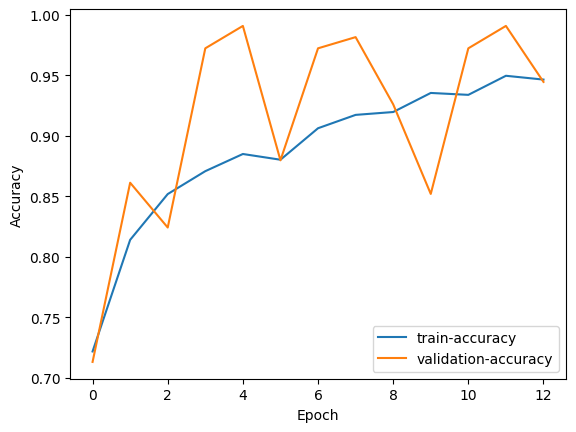

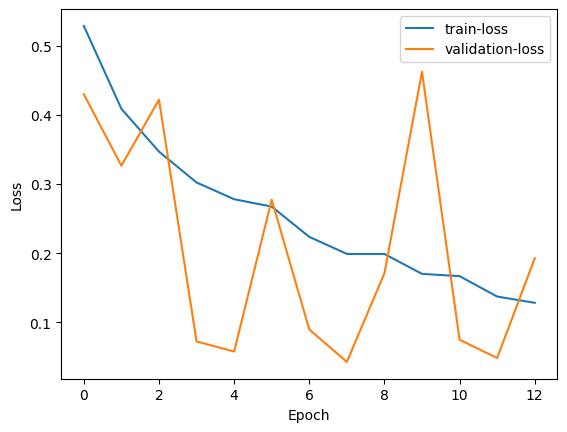

87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 841ms/step - accuracy: 0.9670 - loss: 0.1262
Test Accuracy: 0.9710144996643066


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
import json

# Define file paths
root = '/content/drive/MyDrive/Datasets/E-Waste_Dataset/modified-dataset/Dataset'

# Create a list to hold image paths and their corresponding class labels
data = []
for i in os.listdir(root):
    class_dir = os.path.join(root, i)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, i])

# Create DataFrame from the list
data = pd.DataFrame(data, columns=['path', 'class_'])

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Split data into train, validation, and test sets
def split_data(data, ratio):
    last = int(len(data) * ratio)
    return data[:last], data[last:]

train, test = split_data(data, .8)
validation, train = split_data(train, .08)

# Save CSV files
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
validation.to_csv('valid.csv', index=False)

# Image preprocessing
size = 384
batch_size = 4
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # Increased zoom range
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],  # Added brightness variation
    channel_shift_range=50.0  # Added channel shift
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

valid_generator = ImageDataGenerator(rescale=1.0 / 255)
valid_images = valid_generator.flow_from_dataframe(
    dataframe=validation,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

test_generator = ImageDataGenerator(rescale=1.0 / 255)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)

# Load EfficientNetB0 model as a feature extractor
def build_model(input_shape=(size, size, 3), num_classes=len(train_images.class_indices)):
    inputs = Input(shape=input_shape)

    # Use EfficientNetB0 pre-trained weights for feature extraction
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze the base model layers

    # Fine-tune from a specific layer onward
    fine_tune_at = 100  # Fine-tune from the 100th layer onward (or adjust this as needed)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)  # Dropout layer to avoid overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, output)

    # Compile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=['accuracy'])

    return model

# Build and train the model
model = build_model()

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=20,
    steps_per_epoch=train_images.n // batch_size,
    validation_steps=valid_images.n // batch_size,
    callbacks=[early_stopping],
)

# Save the model
model.save('model.h5')

# Save the class indices to a JSON file
with open('class_indices.json', 'w') as f:
    json.dump(train_images.class_indices, f)

# Plot accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train-accuracy', 'validation-accuracy'], loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train-loss', 'validation-loss'], loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images)
print(f"Test Accuracy: {test_accuracy}")


In [3]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import json

# Load the trained model and class indices
model = tf.keras.models.load_model('/content/model.h5')

# Load class indices
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)
class_labels = list(class_indices.keys())

# JavaScript code to access the webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const btn = document.createElement('button');
            btn.textContent = 'Capture Image';
            div.appendChild(video);
            div.appendChild(btn);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            let resolve;
            const promise = new Promise(r => resolve = r);
            btn.onclick = () => {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getTracks().forEach(t => t.stop());
                div.remove();
                resolve(canvas.toDataURL('image/jpeg', quality));
            };
            return promise;
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture an image from the webcam
image_path = take_photo()

# Read and preprocess the image
img = image.load_img(image_path, target_size=(384, 384))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize the image

# Predict the class
predictions = model.predict(img)

# Get the top predicted class and confidence
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
confidence = predictions[0][predicted_class] * 100  # Convert to percentage

# Classify as E-Waste or Not E-Waste
if confidence > 58.2:
    print(f"E-Waste Detected: {confidence:.2f}% confidence")
else:
    print(f"Not E-Waste: {confidence:.2f}% confidence")


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
E-Waste Detected: 60.19% confidence
